In [3777]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [3778]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

In [3779]:
path = "../Datasets/"
Train = pd.read_csv(path + '/Historical-transaction-data.csv')
StoreInfo = pd.read_csv(path + '/Store-info.csv')
Testing = pd.read_csv(path + '/Testing-data.csv')

In [3780]:
Train = Train.merge(StoreInfo, on='shop_id', how='left')

In [3781]:
Testing.drop("shop_profile", axis=1, inplace=True)


In [3782]:
Submission_testing = Testing.copy()


# Submission_testing = Submission_testing.merge(StoreInfo, on='shop_id', how='left')
# Submission_testing.drop("shop_profile", axis=1, inplace=True)
Submission_testing = Submission_testing.merge(Train, on='shop_id', how='left')

In [3783]:
Submission_testing.drop("shop_profile", axis=1, inplace=True)

In [3784]:
Train.drop_duplicates(inplace=True)

In [3785]:
# Train.to_csv('CombinedData.csv', index=False)

In [3786]:
# Submission_testing.to_csv('SubmissionData.csv', index=False)

In [3787]:
redundant_cols = ['transaction_date', 'invoice_id', 'customer_id']

Train.drop(redundant_cols, axis=1, inplace=True)
Submission_testing.drop(redundant_cols, axis=1, inplace=True)

In [3788]:
features_nom = ['item_description',"shop_id", "shop_profile"]

for feature in features_nom:
    Train[feature] = Train[feature].astype("category")
    if feature == "shop_profile":
        continue
    Submission_testing[feature] = Submission_testing[feature].astype("category")

In [3789]:
Train["shop_id"] = Train["shop_id"].str.replace("SHOP", "").astype(int).astype("category")

In [3790]:
Submission_testing["shop_id"] = Submission_testing["shop_id"].str.replace("SHOP", "").astype(int).astype("category")
StoreInfo["shop_id"] = StoreInfo["shop_id"].str.replace("SHOP", "").astype(int).astype("category")

In [3791]:
#Remove rows with null values for item_description or shop_profile
Train = Train.dropna(subset=['shop_profile'], axis=0)

In [3792]:
from sklearn.compose import ColumnTransformer
#import simpleimputer
from sklearn.impute import SimpleImputer

Submission_testing['shop_profile'] = 'default_value'
ct = ColumnTransformer([("SimpleImputer", SimpleImputer(strategy="constant", fill_value="missing"), ["item_description"])], remainder="passthrough")


Train = pd.DataFrame(ct.fit_transform(Train), columns=Train.columns)

Submission_testing = pd.DataFrame(ct.transform(Submission_testing), columns=Train.columns)


In [3793]:
category_columns = ["shop_id", "item_description", "shop_profile"]

for col in Train.columns:
    if col not in category_columns:
        Train[col] = Train[col].astype("int")
        Submission_testing[col] = Submission_testing[col].astype("int")
    else:
        Train[col] = Train[col].astype("category")
        Submission_testing[col] = Submission_testing[col].astype("category")

In [3794]:

Submission_testing.drop("shop_profile", axis=1, inplace=True)


In [3795]:
Submission_testing.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft
0,FIT O MIXED FRUIT 1L,46,270,1,545
1,FIT O ORANGE 1L,46,290,1,545
2,LEMONADE 1.5L,46,220,2,545
3,FIT O MANGO 200ML,46,180,4,545
4,FIT O MIXED FRUIT 200ML,46,60,1,545


In [3796]:
# suppose x1 and x3 column should have a minimum of zero, define the acceptable ranges for each column

ranges = {'quantity_sold': (0, np.inf)}

# loop over each column and adjust the values outside the acceptable range

for col, (min_val, max_val) in ranges.items():
    Train[col] = np.clip(Train[col], min_val, max_val)
    Submission_testing[col] = np.clip(Submission_testing[col], min_val, max_val)

In [3797]:
def outlier_thresholds(dataframe, column_name, q1=0.05, q2=0.95):
    quartile1 = dataframe[column_name].quantile(0.05)
    quartile3 = dataframe[column_name].quantile(0.95)
    IQR = quartile3 - quartile1
    up_limit = quartile3 + 1.5*IQR
    low_limit = quartile1 - 1.5*IQR
    return low_limit, up_limit

def check_outlier(dataframe, column_name):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name)
    if dataframe[(dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, column_name):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name)
    dataframe.loc[(dataframe[column_name] < low_limit), column_name] = low_limit
    dataframe.loc[(dataframe[column_name] > up_limit), column_name] = up_limit
    
def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    for col in numeric_columns:
        print(col, check_outlier(df, col))
        if check_outlier(df, col):
            replace_with_thresholds(df, col)

In [3798]:
Train.kurt(numeric_only=True)

item_price         360.710060
quantity_sold      378.291737
shop_area_sq_ft      2.967483
dtype: float64

In [3799]:
Train.describe()

,item_price,quantity_sold,shop_area_sq_ft
count,361487.000000,361487.000000,361487.000000
mean,209.686600,1.940855,633.015976
std,168.745897,1.653120,123.623875
min,35.000000,0.000000,298.000000
25%,100.000000,1.000000,605.000000
50%,220.000000,2.000000,617.000000
75%,220.000000,2.000000,676.000000
max,17400.000000,101.000000,1077.000000


In [3800]:
remove_outliers(Train)

item_price True
quantity_sold True
shop_area_sq_ft False


In [3801]:
remove_outliers(Submission_testing)

item_price True
quantity_sold True
shop_area_sq_ft False


In [3802]:
Train.kurt(numeric_only=True)

item_price         9.552890
quantity_sold      8.999245
shop_area_sq_ft    2.967483
dtype: float64

In [3803]:
Train.describe()

,item_price,quantity_sold,shop_area_sq_ft
count,361487.000000,361487.000000,361487.000000
mean,207.800336,1.899030,633.015976
std,148.505967,1.134865,123.623875
min,35.000000,0.000000,298.000000
25%,100.000000,1.000000,605.000000
50%,220.000000,2.000000,617.000000
75%,220.000000,2.000000,676.000000
max,1102.500000,8.500000,1077.000000


In [3804]:
# Create price-related features
Train['total_sales']= Train['item_price'] * Train['quantity_sold']
Submission_testing['total_sales']= Submission_testing['item_price'] * Submission_testing['quantity_sold']

# Create a new feature for the total no of unique item_description per shop_id
n_unique = Train.groupby(['shop_id'])['item_description'].nunique().reset_index()
# Create a new freature for the total no of rows per shop_id
n_count = Train.groupby(['shop_id'])['item_description'].count().reset_index()

In [3805]:
sub_n_unique = Submission_testing.groupby(['shop_id'])['item_description'].nunique().reset_index()
# Create a new freature for the total no of rows per shop_id
sub_n_count = Submission_testing.groupby(['shop_id'])['item_description'].count().reset_index()

In [3806]:

# Aggregate X_train_scaled by shop_id and add all the total_sales values and prevent empty values

Train_cum = Train.groupby(['shop_id'], sort=False).agg({'total_sales':'sum'})
Submission_testing_cum = Submission_testing.groupby(['shop_id'], sort='False').agg({'total_sales':'sum'})


In [3807]:

Train_cum = Train_cum.merge(StoreInfo, on='shop_id', how='left')
Train_cum = Train_cum.merge(n_unique, on='shop_id', how='left')
Train_cum = Train_cum.merge(n_count, on='shop_id', how='left')
# rename item_description_x to item_description_count
Train_cum.rename(columns={'item_description_x':'unique_items', 'item_description_y':'order_count'}, inplace=True)
Train_cum.head()


,shop_id,total_sales,shop_area_sq_ft,shop_profile,unique_items,order_count
0,8,119317.50,678,Moderate,32,244
1,112,1034182.50,668,Moderate,36,2236
2,55,879470.00,720,Moderate,37,2275
3,3,1743728.75,810,High,36,3422
4,71,887750.00,704,Low,36,2307


In [3808]:
Train_cum = Train_cum.dropna(subset=['shop_profile'], axis=0)
Train_cum.drop("shop_profile", axis=1, inplace=True)

Submission_testing_cum = Submission_testing_cum.merge(StoreInfo, on='shop_id', how='left')
Submission_testing_cum = Submission_testing_cum.merge(sub_n_unique, on='shop_id', how='left')
Submission_testing_cum = Submission_testing_cum.merge(sub_n_count, on='shop_id', how='left')
Submission_testing_cum.rename(columns={'item_description_x':'unique_items', 'item_description_y':'order_count'}, inplace=True)
Submission_testing_cum.drop("shop_profile", axis=1, inplace=True)


In [3809]:
# new feature: total_sales per sq ft of the shop
Train_cum['sales_per_sq_ft'] = Train_cum['total_sales'] / Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_per_sq_ft'] = Submission_testing_cum['total_sales'] / Submission_testing_cum['shop_area_sq_ft']

# new feature : difference between the total_sales and total_sales_per_sq_ft
Train_cum['sales_minus_shop_area'] = Train_cum['total_sales'] - Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_minus_shop_area'] = Submission_testing_cum['total_sales'] - Submission_testing_cum['shop_area_sq_ft']

# new feature: addition of the total_sales and total_sales_per_sq_ft
Train_cum['sales_plus_shop_area'] = Train_cum['total_sales'] + Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_plus_shop_area'] = Submission_testing_cum['total_sales'] + Submission_testing_cum['shop_area_sq_ft']

# new feature : multiplication of the total_sales and total_sales_per_sq_ft
Train_cum['sales_times_shop_area'] = Train_cum['total_sales'] * Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_times_shop_area'] = Submission_testing_cum['total_sales'] * Submission_testing_cum['shop_area_sq_ft']

In [3810]:
# Remove rows with zero total_sales

Train_cum = Train_cum[Train_cum['total_sales'] != 0]
Submission_testing_cum = Submission_testing_cum[Submission_testing_cum['total_sales'] != 0]

Train_cum.drop("shop_area_sq_ft", axis=1, inplace=True)
Train_cum = Train_cum.merge(StoreInfo, on='shop_id', how='left')
Submission_testing_cum.drop("shop_area_sq_ft", axis=1, inplace=True)
Submission_testing_cum = Submission_testing_cum.merge(StoreInfo, on='shop_id', how='left')

In [3811]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [3812]:
y_new_train = Train_cum["shop_profile"]
Train_cum.drop("shop_profile", axis=1, inplace=True)
Submission_testing_cum.drop("shop_profile", axis=1, inplace=True)
y_new_train = le.fit_transform(y_new_train)

# Feature Scaling

In [3813]:
Submission_testing_cum.head()

,shop_id,total_sales,unique_items,order_count,sales_per_sq_ft,sales_minus_shop_area,sales_plus_shop_area,sales_times_shop_area,shop_area_sq_ft
0,2,2775490.00,36,4800,4357.127159,2774853.00,2776127.00,1.767987e+09,637
1,19,2117897.50,32,3766,5153.035280,2117486.50,2118308.50,8.704559e+08,411
2,23,2150591.25,37,4103,3485.561183,2149974.25,2151208.25,1.326915e+09,617
3,24,1259630.00,36,2883,1863.357988,1258954.00,1260306.00,8.515099e+08,676
4,29,1823867.50,36,3799,3055.054439,1823270.50,1824464.50,1.088849e+09,597


In [3814]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

scaled_columns = ["unique_items", "order_count", "total_sales", "sales_per_sq_ft", "sales_minus_shop_area", "sales_plus_shop_area", "sales_times_shop_area", "shop_area_sq_ft"]
ct = ColumnTransformer([("MinMaxScaler", MinMaxScaler(), scaled_columns)], remainder="passthrough")


In [3815]:
scaled_X_train.head()

,unique_items,order_count,total_sales,sales_per_sq_ft,sales_minus_shop_area,sales_plus_shop_area,sales_times_shop_area,shop_area_sq_ft,shop_id
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.487805,8.0
1,0.8,0.336600,0.261426,0.211198,0.261419,0.261433,0.192341,0.474968,112.0
2,1.0,0.343190,0.217216,0.160916,0.217196,0.217236,0.174172,0.541720,55.0
3,0.8,0.537006,0.464181,0.304249,0.464127,0.464236,0.419889,0.657253,3.0
4,0.8,0.348597,0.219582,0.166999,0.219567,0.219598,0.171573,0.521181,71.0


In [3816]:


scaled_X_train = pd.DataFrame(ct.fit_transform(Train_cum), columns=scaled_columns+["shop_id"])
scaled_X_submission = pd.DataFrame(ct.transform(Submission_testing_cum), columns=scaled_columns+["shop_id"])


In [3817]:
scaled_X_train.head()

,unique_items,order_count,total_sales,sales_per_sq_ft,sales_minus_shop_area,sales_plus_shop_area,sales_times_shop_area,shop_area_sq_ft,shop_id
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.487805,8.0
1,0.8,0.336600,0.261426,0.211198,0.261419,0.261433,0.192341,0.474968,112.0
2,1.0,0.343190,0.217216,0.160916,0.217196,0.217236,0.174172,0.541720,55.0
3,0.8,0.537006,0.464181,0.304249,0.464127,0.464236,0.419889,0.657253,3.0
4,0.8,0.348597,0.219582,0.166999,0.219567,0.219598,0.171573,0.521181,71.0


In [3818]:
# set scaled_X_train shop_id as categorical and other columns as numerical

category_columns = ["shop_id"]

for col in scaled_X_train.columns:
    if col not in category_columns:
        scaled_X_train[col] = scaled_X_train[col].astype("float")
        scaled_X_submission[col] = scaled_X_submission[col].astype("float")
    else:
        scaled_X_train[col] = scaled_X_train[col].astype("category")
        scaled_X_submission[col] = scaled_X_submission[col].astype("category")

In [3819]:
## Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X_train, y_new_train, test_size = 0.2, random_state = 42)

In [3820]:
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

# Metrics

In [3821]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

def score_classification(model, df1_x, df1_y, df2_x, df2_y):
  print(model)
  df1_x = df1_x.copy()
  df2_x = df2_x.copy() 
  ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

  # One hot encoding for the item_description column

  df1_encoded = ct2.fit_transform(df1_x[["shop_id"]])
  df1_x = pd.concat([df1_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

  df2_encoded = ct2.transform(df2_x[["shop_id"]])
  df2_x = pd.concat([df2_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

  df1_x.columns = df1_x.columns.astype(str)
  df2_x.columns = df2_x.columns.astype(str)
  # Fit the model  
  model.fit(df1_x, df1_y)

  # Make predictions
  y_pred = model.predict(df2_x)

  # Evaluate the model
  accuracy = accuracy_score(df2_y, y_pred)
  precision = precision_score(df2_y, y_pred,  average='macro')
  recall = recall_score(df2_y, y_pred,  average='macro')
  f1 = f1_score(df2_y, y_pred,  average='macro')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

In [3822]:
def outputResult(model, df1_x, df1_y, test, le):
    print(model)
    df1_x = df1_x.copy()
    df2_x = test.copy()
    
    ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

    # One hot encoding for the item_description column

    df1_encoded = ct2.fit_transform(df1_x[["shop_id"]])
    df1_x = pd.concat([df1_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

    df2_encoded = ct2.transform(df2_x[["shop_id"]])
    df2_x = pd.concat([df2_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

    df1_x.columns = df1_x.columns.astype(str)
    df2_x.columns = df2_x.columns.astype(str)

    # Fit the model on the training data
    model.fit(df1_x, df1_y)
    
    # Make predictions on the test data
    y_pred = model.predict(df2_x)
    
    # Inverse transform the encoded predictions to the original shop profiles
    y_pred = le.inverse_transform(y_pred)    
    
    # Create a dataframe with the predicted shop profiles
    results_df = pd.DataFrame({'shop_id': test.shop_id, 'shop_profile': y_pred})    
    # rename the shop_id column with the word "SHOP" and add a 0 in front of the shop_id
    results_df["shop_id"] = results_df["shop_id"].astype(int).astype(str)
    results_df["shop_id"] = "SHOP" + results_df["shop_id"].str.zfill(3)
    # results_df.rename(columns={'shop_id': 'SHOP0' + results_df.shop_id.astype(str)}, inplace=True)
    results_df.drop_duplicates(inplace=True)
    
    # Access the global testing dataframe
    results_final = pd.merge(Testing, results_df, on="shop_id", how="left")
    # Write the dataframe to a CSV file
    results_final.to_csv('predictions'+str(model).strip("()")+'.csv', index=False)

# Modelling

In [3823]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 55 to 51
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   unique_items           80 non-null     float64 
 1   order_count            80 non-null     float64 
 2   total_sales            80 non-null     float64 
 3   sales_per_sq_ft        80 non-null     float64 
 4   sales_minus_shop_area  80 non-null     float64 
 5   sales_plus_shop_area   80 non-null     float64 
 6   sales_times_shop_area  80 non-null     float64 
 7   shop_area_sq_ft        80 non-null     float64 
 8   shop_id                80 non-null     category
dtypes: category(1), float64(8)
memory usage: 10.6 KB


In [3824]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

In [3825]:
score_classification(logr, X_train, y_train, X_test, y_test)

LogisticRegression()
Accuracy: 0.45
Precision: 0.2996632996632997
Recall: 0.5416666666666666
F1 Score: 0.3805668016194332


In [3826]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()


In [3827]:

score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.55
Precision: 0.5571428571428572
Recall: 0.625
F1 Score: 0.5538461538461538


In [3828]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

In [3829]:
# Define the hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}




In [3830]:

# # Use grid search cross-validation to find the best hyperparameters
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding accuracy score
# print("Best Hyperparameters: ", grid_search.best_params_)
# print("Best Accuracy Score: ", grid_search.best_score_)

In [3831]:
rfc.set_params(max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100)

RandomForestClassifier(min_samples_leaf=4)

In [3832]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier(min_samples_leaf=4)
Accuracy: 0.4
Precision: 0.2814814814814815
Recall: 0.5
F1 Score: 0.35327635327635326


In [3833]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1)

In [3834]:
score_classification(svm, X_train, y_train, X_test, y_test)

SVC(C=1, kernel='linear')
Accuracy: 0.45
Precision: 0.2996632996632997
Recall: 0.5416666666666666
F1 Score: 0.3805668016194332


In [3835]:
from sklearn.ensemble import GradientBoostingClassifier

In [3836]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)

In [3837]:
score_classification(gbm, X_train, y_train, X_test, y_test)

GradientBoostingClassifier(random_state=1)
Accuracy: 0.55
Precision: 0.5886243386243386
Recall: 0.625
F1 Score: 0.5495726495726495


In [3838]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [3839]:
score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier()
Accuracy: 0.45
Precision: 0.4428571428571429
Recall: 0.5416666666666666
F1 Score: 0.4581196581196581


In [3840]:

from sklearn.pipeline import Pipeline
import numpy as np

# Define the parameter grid to search over
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 20, 30, 40, 50],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Create a pipeline to preprocess the data and apply KNN
pipeline = Pipeline([ 
    ('knn', KNeighborsClassifier())
])

# Create a grid search object to find the best parameters
grid_search_knn = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)



In [3841]:
# # Fit the grid search object on the data
# grid_search_knn.fit(X_train, y_train)

# # Print the best parameters found
# print("Best parameters:", grid_search_knn.best_params_)


In [3842]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False).split(range(25))

from sklearn.model_selection import cross_val_score

knn2 = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1_macro')
print(scores)

[0.         0.19047619 0.11111111 0.         0.3        0.22222222
 0.08333333 0.11111111 0.37777778 0.49047619]


In [3843]:
# Set the best parameters found by GridSearchCV
knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'})

score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier(leaf_size=10, metric='euclidean', p=1, weights='distance')
Accuracy: 0.5
Precision: 0.5138888888888888
Recall: 0.5833333333333334
F1 Score: 0.5345238095238095


In [3844]:
scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[0.375 0.625 0.25  0.375 0.625 0.875 0.375 0.5   0.5   0.375]


In [3845]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()


In [3846]:

score_classification(nb, X_train, y_train, X_test, y_test)

GaussianNB()
Accuracy: 0.4
Precision: 0.13333333333333333
Recall: 0.3333333333333333
F1 Score: 0.1904761904761905


In [3847]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5)

In [3848]:
score_classification(xgb_model, X_train, y_train, X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy: 0.55
Precision: 0.5703703703703703
Recall: 0.625
F1 Score: 0.5494505494505494


In [3849]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 55 to 51
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   unique_items           80 non-null     float64 
 1   order_count            80 non-null     float64 
 2   total_sales            80 non-null     float64 
 3   sales_per_sq_ft        80 non-null     float64 
 4   sales_minus_shop_area  80 non-null     float64 
 5   sales_plus_shop_area   80 non-null     float64 
 6   sales_times_shop_area  80 non-null     float64 
 7   shop_area_sq_ft        80 non-null     float64 
 8   shop_id                80 non-null     category
dtypes: category(1), float64(8)
memory usage: 10.6 KB


In [3850]:

# score_classification(xgb_model, X_train, y_train, X_test, y_test)

In [3851]:
# Create a list of classifiers to compare
classifiers = [logr, dtc, knn, rfc, nb, svm, gbm]

# Create X and y data

# Cross-validation
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


LogisticRegression
F1 Score: 0.54 (+/- 0.14)
DecisionTreeClassifier
F1 Score: 0.41 (+/- 0.24)
KNeighborsClassifier
F1 Score: 0.29 (+/- 0.16)
RandomForestClassifier
F1 Score: 0.48 (+/- 0.27)
GaussianNB
F1 Score: 0.50 (+/- 0.35)
SVC
F1 Score: 0.50 (+/- 0.22)
GradientBoostingClassifier
F1 Score: 0.48 (+/- 0.18)


In [3852]:
X_train.head()

,unique_items,order_count,total_sales,sales_per_sq_ft,sales_minus_shop_area,sales_plus_shop_area,sales_times_shop_area,shop_area_sq_ft,shop_id
55,0.8,0.978878,0.774944,0.679177,0.774933,0.774955,0.525359,0.409499,11.0
88,1.0,0.686043,0.545865,0.461004,0.545856,0.545873,0.384101,0.439024,39.0
26,0.8,0.638391,0.525072,0.418444,0.525053,0.525090,0.391630,0.485237,51.0
42,1.0,0.516729,0.396202,0.315764,0.396188,0.396216,0.295493,0.485237,83.0
69,0.8,0.312606,0.283587,0.303881,0.283623,0.283551,0.155739,0.281130,120.0


# Feature Engineering

In [3853]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
  # all discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="Mutual Information Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores


def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width,scores)
  plt.yticks(width, ticks)
  plt.title("Mututal Information Scores")

In [3854]:
# no of null values in each column
# print(y_train.isnull().sum())

In [3855]:
# y_train.shape

In [3856]:
# mi_scores = make_mi_scores(X_train, y_train)
# mi_scores

In [3857]:
from sklearn.decomposition import PCA

def apply_pca(X):
  pca= PCA()
  df1_x = X.copy()

  X_pca = pca.fit_transform(df1_x)
  component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
  X_pca = pd.DataFrame(X_pca, columns=component_names)
  #create loadings
  loadings = pd.DataFrame(
  pca.components_.T,
  columns = component_names,
  index=df1_x.columns,
  )
  return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
  fig, axs = plt.subplots(1,2)
  n = pca.n_components_
  grid = np.arange(1, n+1)
  evr = pca.explained_variance_ratio_
  axs[0].bar(grid,evr)
  axs[0].set(
      xlabel="Component",title="% Explained Variance", ylim=(0.0,1.0)             )
  #Cumulative Variance
  cv = np.cumsum(evr)
  axs[1].plot(np.r_[0,grid], np.r_[0,cv], "o-")
  axs[1].set(xlabel="Component", title="% Cumulatve Variance", ylim=(0.0, 1.0))
  fig.set(figwidth=8, dpi=100)
  return axs

In [3858]:
X_train["shop_id"].astype("int").astype("category")

55     11
88     39
26     51
42     83
69    120
     ... 
60    111
71     36
14    103
92     58
51    105
Name: shop_id, Length: 80, dtype: category
Categories (80, int64): [1, 3, 5, 6, ..., 124, 125, 126, 127]

In [3859]:
 # plot a pairplot for all the features
y_train_df = pd.DataFrame(y_train, columns=['target'])
# X_train.index = range(len(X_train))
# combine X_train and y_train into a single dataframe
df_concat = pd.concat([X_train, y_train_df], axis=1)

In [3860]:

# create the pairplot
# sns.pairplot(df_concat, hue='target')

In [3861]:
from sklearn.cluster import KMeans

def cluster_labels(df, features, n_clusters=6):
  X = df.copy()
  X_new = X.loc[:, features]
  kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=0)
  X_new["Cluster"] = kmeans.fit_predict(X_new)
  X_new["Cluster"] = X_new.Cluster.astype("category")
  return X_new

In [3862]:
def plot_cluster(X, y):
  Xy = X.copy()
  Xy["y"] = y
  Xy.head()
  sns.relplot(
      x="value", y="y", hue="Cluster", col="variable",
      height=4, aspect=1, facet_kws={'sharex':False}, col_wrap=3,
      data=Xy.melt(
          value_vars=features, id_vars=["y", "Cluster"]
      )
  )

In [3863]:
features = X_train.columns
cluster_df1_x = cluster_labels(X_train, features, n_clusters=3)
cluster_df2_x = cluster_labels(X_test, features, n_clusters=3)
# cluster_df3_x = cluster_labels(Submission_testing, features, n_clusters=3)
cluster_df1_x.head()

,unique_items,order_count,total_sales,sales_per_sq_ft,sales_minus_shop_area,sales_plus_shop_area,sales_times_shop_area,shop_area_sq_ft,shop_id,Cluster
55,0.8,0.978878,0.774944,0.679177,0.774933,0.774955,0.525359,0.409499,11.0,1
88,1.0,0.686043,0.545865,0.461004,0.545856,0.545873,0.384101,0.439024,39.0,1
26,0.8,0.638391,0.525072,0.418444,0.525053,0.525090,0.391630,0.485237,51.0,0
42,1.0,0.516729,0.396202,0.315764,0.396188,0.396216,0.295493,0.485237,83.0,0
69,0.8,0.312606,0.283587,0.303881,0.283623,0.283551,0.155739,0.281130,120.0,2


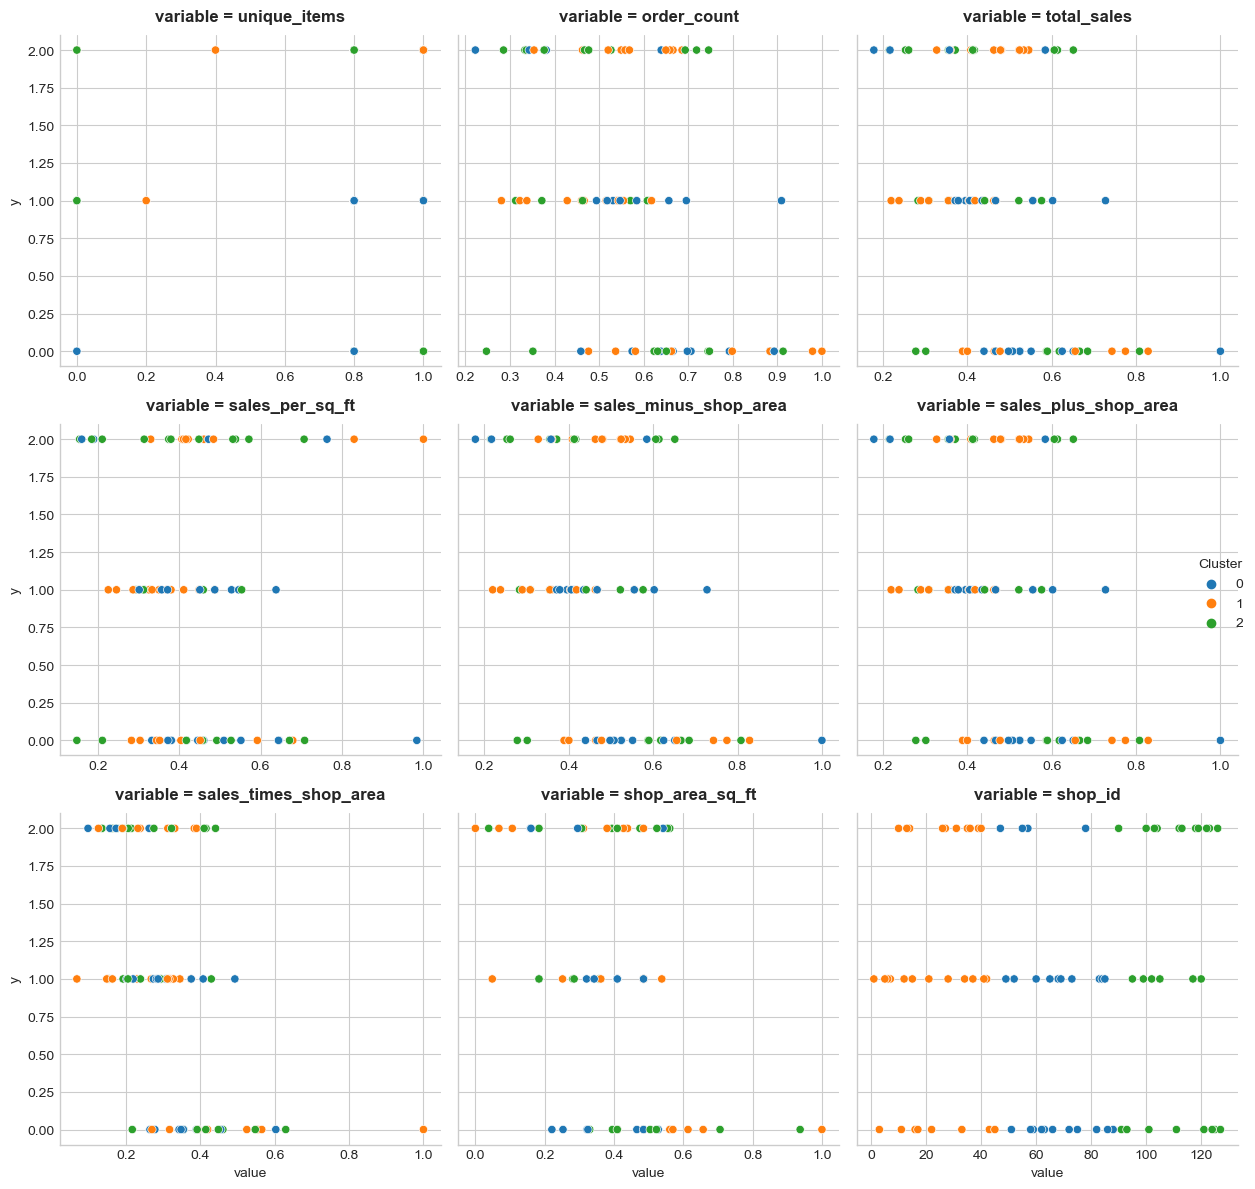

In [3864]:
plot_cluster(cluster_df1_x, y_train)

In [3865]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 55 to 51
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   unique_items           80 non-null     float64 
 1   order_count            80 non-null     float64 
 2   total_sales            80 non-null     float64 
 3   sales_per_sq_ft        80 non-null     float64 
 4   sales_minus_shop_area  80 non-null     float64 
 5   sales_plus_shop_area   80 non-null     float64 
 6   sales_times_shop_area  80 non-null     float64 
 7   shop_area_sq_ft        80 non-null     float64 
 8   shop_id                80 non-null     category
dtypes: category(1), float64(8)
memory usage: 12.6 KB


In [3866]:
score_classification(rfc, cluster_df1_x, y_train, cluster_df2_x, y_test)

RandomForestClassifier(min_samples_leaf=4)
Accuracy: 0.5
Precision: 0.5370370370370371
Recall: 0.5833333333333334
F1 Score: 0.4930069930069931


In [3867]:
# cluster_df1_x.info()

In [3868]:
# cluster_df1_x.drop(['shop_area_sq_ft'], axis=1, inplace=True)
# cluster_df2_x.drop(['shop_area_sq_ft'], axis=1, inplace=True)

In [3869]:
# cluster_df1_x.drop(columns=['sales_plus_shop_area', 'sales_minus_shop_area', 'unique_items'], axis=1, inplace=True)
# cluster_df2_x.drop(columns=['sales_plus_shop_area', 'sales_minus_shop_area', 'unique_items'], axis=1, inplace=True)

In [3870]:
score_classification(knn, cluster_df1_x, y_train, cluster_df2_x, y_test)

KNeighborsClassifier(leaf_size=10, metric='euclidean', p=1, weights='distance')
Accuracy: 0.5
Precision: 0.5
Recall: 0.5833333333333334
F1 Score: 0.49999999999999994


In [3871]:
# pca, X_pca, loadings = apply_pca(X_train)
# print(loadings)

In [3872]:
score_classification(gbm, X_train, y_train, X_test, y_test)

GradientBoostingClassifier(random_state=1)
Accuracy: 0.55
Precision: 0.5886243386243386
Recall: 0.625
F1 Score: 0.5495726495726495


In [3873]:
X_train.drop(columns=['sales_plus_shop_area'], axis=1, inplace=True)
X_test.drop(columns=['sales_plus_shop_area'], axis=1, inplace=True)

In [3874]:
score_classification(gbm, X_train, y_train, X_test, y_test)

GradientBoostingClassifier(random_state=1)
Accuracy: 0.55
Precision: 0.5886243386243386
Recall: 0.625
F1 Score: 0.5495726495726495


In [3875]:
X_train.drop(columns=['sales_minus_shop_area'], axis=1, inplace=True)
X_test.drop(columns=['sales_minus_shop_area'], axis=1, inplace=True)


In [3876]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.55
Precision: 0.5571428571428572
Recall: 0.625
F1 Score: 0.5538461538461538


In [3877]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.52 (+/- 0.16)
DecisionTreeClassifier
F1 Score: 0.43 (+/- 0.23)
KNeighborsClassifier
F1 Score: 0.29 (+/- 0.16)
RandomForestClassifier
F1 Score: 0.58 (+/- 0.29)
GaussianNB
F1 Score: 0.53 (+/- 0.24)
SVC
F1 Score: 0.51 (+/- 0.18)
GradientBoostingClassifier
F1 Score: 0.46 (+/- 0.17)


In [3878]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.55
Precision: 0.5571428571428572
Recall: 0.625
F1 Score: 0.5538461538461538


In [3879]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 55 to 51
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   unique_items           80 non-null     float64 
 1   order_count            80 non-null     float64 
 2   total_sales            80 non-null     float64 
 3   sales_per_sq_ft        80 non-null     float64 
 4   sales_times_shop_area  80 non-null     float64 
 5   shop_area_sq_ft        80 non-null     float64 
 6   shop_id                80 non-null     category
dtypes: category(1), float64(6)
memory usage: 11.4 KB


In [3775]:
X_train.drop(columns=['unique_items', 'order_count'], axis=1, inplace=True)
X_test.drop(columns=['unique_items', 'order_count'], axis=1, inplace=True)

In [3880]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.55
Precision: 0.5571428571428572
Recall: 0.625
F1 Score: 0.5538461538461538


In [3884]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier(min_samples_leaf=4)
Accuracy: 0.4
Precision: 0.2814814814814815
Recall: 0.5
F1 Score: 0.35327635327635326


In [3883]:
scaled_X_submission = scaled_X_submission[X_train.columns]
outputResult(dtc, X_train, y_train, scaled_X_submission, le)

DecisionTreeClassifier()


In [3660]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier(min_samples_leaf=4)
Accuracy: 0.5
Precision: 0.6481481481481481
Recall: 0.5833333333333334
F1 Score: 0.46438746438746437


In [3661]:
X_train.drop(columns=['shop_area_sq_ft'], axis=1, inplace=True)
X_test.drop(columns=['shop_area_sq_ft'], axis=1, inplace=True)
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


LogisticRegression
F1 Score: 0.50 (+/- 0.20)
DecisionTreeClassifier
F1 Score: 0.45 (+/- 0.09)
KNeighborsClassifier
F1 Score: 0.29 (+/- 0.16)
RandomForestClassifier
F1 Score: 0.53 (+/- 0.24)
GaussianNB
F1 Score: 0.50 (+/- 0.19)
SVC
F1 Score: 0.51 (+/- 0.22)
GradientBoostingClassifier
F1 Score: 0.43 (+/- 0.22)


In [3666]:
score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier(leaf_size=10, metric='euclidean', p=1, weights='distance')
Accuracy: 0.45
Precision: 0.4428571428571429
Recall: 0.5416666666666666
F1 Score: 0.4581196581196581


In [3541]:
X_train.drop(columns=['order_count', 'unique_items'], axis=1, inplace=True)
X_test.drop(columns=['order_count', 'unique_items'], axis=1, inplace=True)


In [3667]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.50 (+/- 0.20)
DecisionTreeClassifier
F1 Score: 0.43 (+/- 0.11)
KNeighborsClassifier
F1 Score: 0.29 (+/- 0.16)
RandomForestClassifier
F1 Score: 0.51 (+/- 0.33)
GaussianNB
F1 Score: 0.50 (+/- 0.19)
SVC
F1 Score: 0.51 (+/- 0.22)
GradientBoostingClassifier
F1 Score: 0.43 (+/- 0.22)


In [3543]:
# scaled_X_submission = scaled_X_submission[X_train.columns]
# outputResult(gbm, X_train, y_train, scaled_X_submission, le)

In [3544]:
# Define the hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



In [3670]:
# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

ValueError: Invalid parameter 'knn' for estimator RandomForestClassifier(min_samples_leaf=4). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [3669]:
# rfc.set_params(**grid_search.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier(max_depth=5, min_samples_split=10)
Accuracy: 0.5
Precision: 0.5370370370370371
Recall: 0.5833333333333334
F1 Score: 0.4930069930069931


In [ ]:
# Fit the grid search object on the data
# grid_search_knn.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__leaf_size': [10, 20, 30, 40, 50],
                         'knn__metric': ['euclidean', 'manhattan', 'chebyshev',
                                         'minkowski'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']})

In [ ]:

# Print the best parameters found
# print("Best parameters:", grid_search_knn.best_params_)

Best parameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}


In [ ]:
# knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'})
knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'})


KNeighborsClassifier(leaf_size=10, metric='euclidean', p=1, weights='distance')

In [ ]:
X_train.head()

,total_sales,sales_per_sq_ft,sales_times_shop_area,shop_id
55,0.571254,0.504111,0.529707,11.0
88,0.457722,0.389110,0.440672,39.0
26,0.379510,0.304678,0.386956,51.0
42,0.257603,0.206825,0.262636,83.0
69,0.192164,0.207127,0.144571,120.0


In [3672]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.5
Precision: 0.5
Recall: 0.5833333333333334
F1 Score: 0.5186147186147186


In [ ]:
score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier(leaf_size=10, metric='euclidean', p=1, weights='distance')
Accuracy: 0.5
Precision: 0.5095238095238095
Recall: 0.5416666666666666
F1 Score: 0.5222222222222221


In [ ]:
score_classification(nb, X_train, y_train, X_test, y_test)

GaussianNB()
Accuracy: 0.4
Precision: 0.13333333333333333
Recall: 0.3333333333333333
F1 Score: 0.1904761904761905


In [ ]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.55
Precision: 0.5476190476190476
Recall: 0.625
F1 Score: 0.563059163059163


In [ ]:
scaled_X_submission = scaled_X_submission[X_train.columns]

In [ ]:
outputResult(knn, X_train, y_train, scaled_X_submission, le)

KNeighborsClassifier(leaf_size=10, metric='euclidean', weights='distance')
